In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from datetime import datetime
import pandas as pd
from tensorflow.keras.utils import plot_model

# Define hyperparameters
latent_dim = 300
epochs = 5000
batch_size = 32000
learning_rate = 0.0001
delta_loss = 0.002

# Load the data
IQ_x_tuple = np.load('dataset/sent_data_tuple.npy')
IQ_y_tuple = np.load('dataset/received_data_tuple_sync-phase.npy')  # Normalized and phase-synchronized

# Load the new data
IQ_x_tuple2 = np.load('dataset/sent_data_tuple2.npy')
IQ_y_tuple2 = np.load('dataset/received_data_tuple_sync-phase2.npy')  # Normalized and phase-synchronized

# Encoder
def build_encoder(latent_dim, input_dim=2):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dense(32, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    model = models.Model(inputs, [z_mean, z_log_var], name='encoder')
    return model, z_mean, z_log_var

# Decoder
def build_decoder(latent_dim, output_dim=2):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(latent_inputs)
    x = layers.Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dense(256, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001))(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

# Sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Custom loss function for VAE
def custom_iq_loss(y_true, y_pred):
    y_true_complex = tf.complex(y_true[:, 0], y_true[:, 1])
    y_pred_complex = tf.complex(y_pred[:, 0], y_pred[:, 1])
    error_magnitude = tf.abs(y_true_complex - y_pred_complex)
    return tf.reduce_mean(tf.square(error_magnitude))

# Assemble the model
encoder, z_mean, z_log_var = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(IQ_x_tuple, IQ_y_tuple, test_size=0.2, random_state=52)

# Compile and train the VAE
vae_inputs = encoder.input
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
vae_outputs = decoder(z)
vae = models.Model(vae_inputs, vae_outputs, name='vae')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=custom_iq_loss)

# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=delta_loss, restore_best_weights=True)

# Train the VAE
print("Starting VAE training...")
history = vae.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stopping])
print("VAE training completed.")

# Save the trained VAE model
tf.saved_model.save(vae, 'vae_model_savedmodel')
print("Model saved as 'vae_model_savedmodel'")



2024-06-17 15:47:16.124436: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 15:47:16.149438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 15:47:16.562366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-17 15:47:17.305438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

Starting VAE training...
Epoch 1/5000


I0000 00:00:1718650038.651197  261362 service.cc:145] XLA service 0x7d9c50011b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718650038.651230  261362 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-06-17 15:47:18.685037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-17 15:47:18.809234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


13/63 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3903

I0000 00:00:1718650040.700936  261362 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 1.3523 - val_loss: 1.2794
Epoch 2/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2611 - val_loss: 1.1509
Epoch 3/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0108 - val_loss: 0.6492
Epoch 4/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6143 - val_loss: 0.5489
Epoch 5/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5356 - val_loss: 0.4994
Epoch 6/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4888 - val_loss: 0.4586
Epoch 7/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4493 - val_loss: 0.4224
Epoch 8/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4140 - val_loss: 0.3896
Epoch 9/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3819 - val_loss: 0.3593
Epoch 10/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3523 - val_loss: 0.3315
Epoch 11/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3249 - val_loss: 0.3057
Epoch 12/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 

INFO:tensorflow:Assets written to: vae_model_savedmodel/assets


Model saved as 'vae_model_savedmodel'


Model file found.
Model successfully loaded.


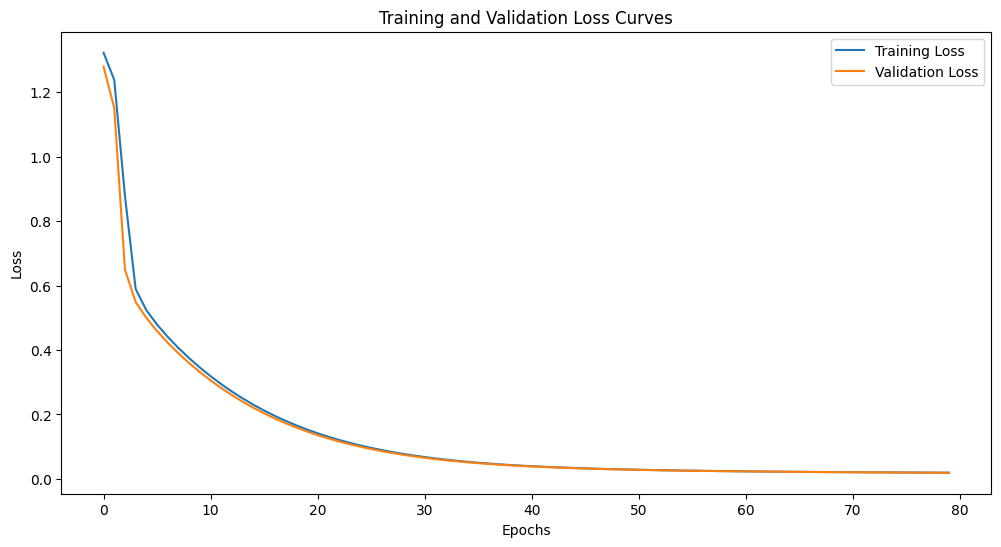

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 435us/step
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 31s 402us/step


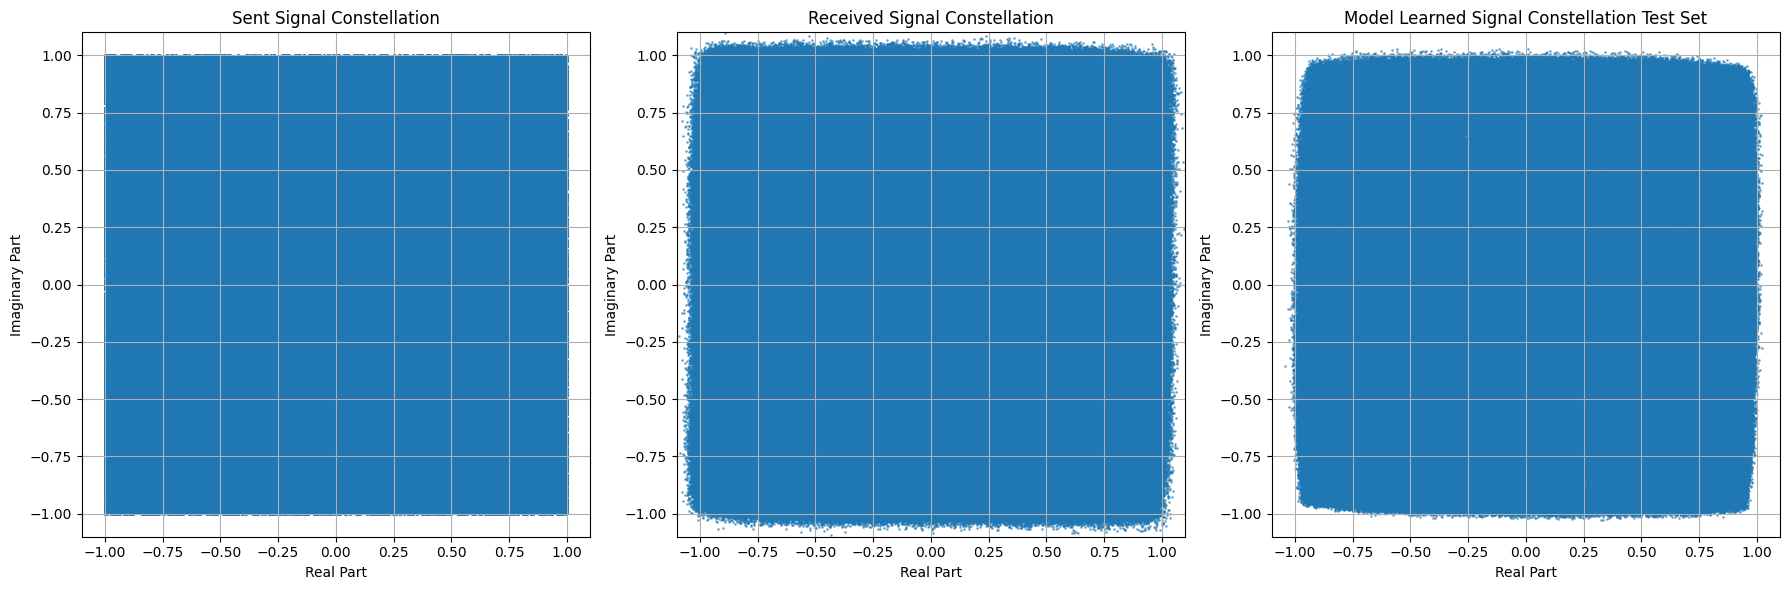

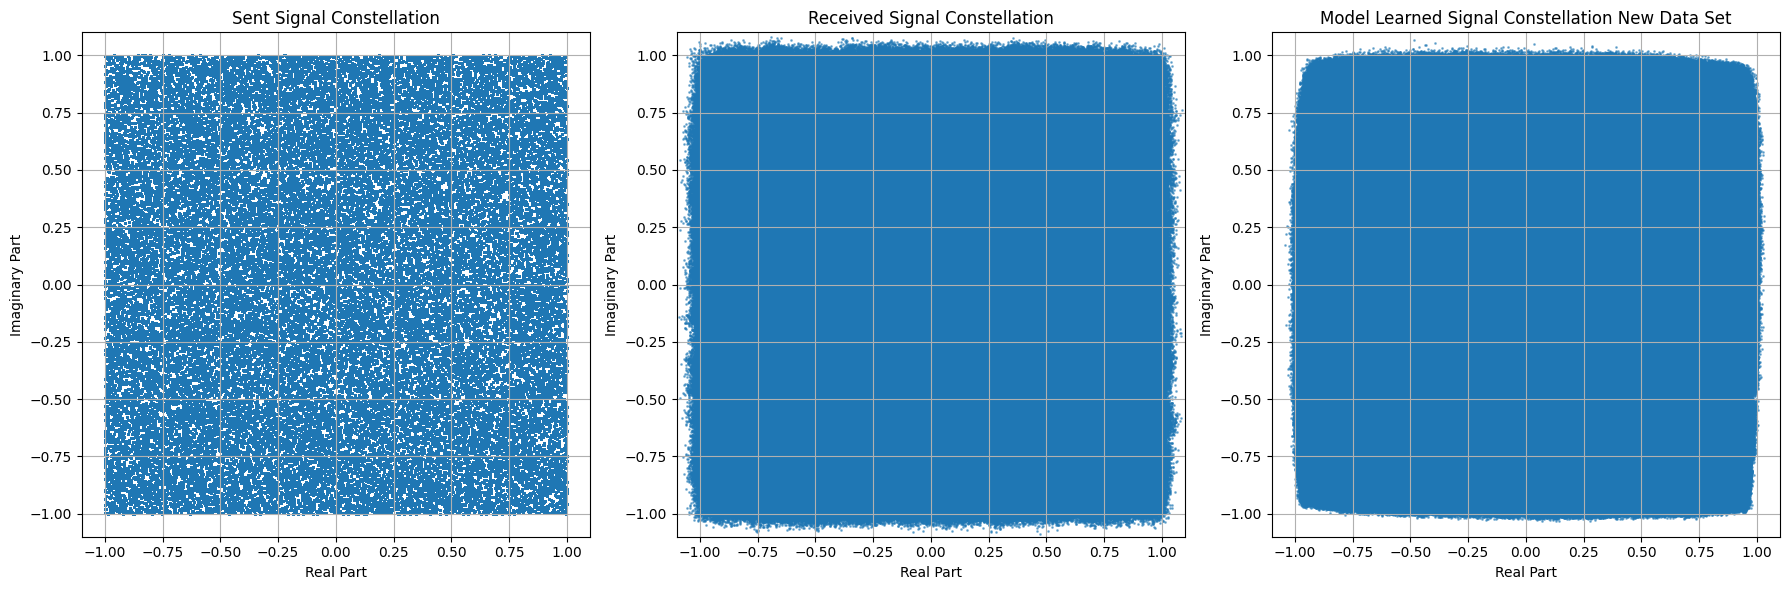

EVM between originally sent and received (%): 4.43301647901535, dB: -27.0660138130188
EVM between originally sent and model learned (test set) (%): 3.0162036418914795, dB: -30.410785675048828
Difference in EVM (%): -1.4168128371238708
EVM between originally sent and received for new data set (%): 4.5805614441633224, dB: -26.781625747680664
EVM between originally sent and model learned for new data set (%): 3.0100561678409576, dB: -30.428507328033447
Difference in EVM for new data set (%): -1.5705052763223648


In [2]:

# Load saved VAE model # That model was created in the main VAE code.
model_path = 'vae_model_savedmodel'
if os.path.exists(model_path):
    print("Model file found.")
    try:
        vae_loaded = tf.keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')
        print("Model successfully loaded.")
    except Exception as e:
        print(f"Error loading the model: {e}")
        traceback.print_exc()
        vae_loaded = None
else:
    print("Model file not found. Please check the file path.")
    vae_loaded = None


real_epochs = len(history.history['loss'])

# Save the loss curves for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

# Generate predictions for Y from X using the trained model
Y_pred = vae.predict(X_test)
Y_pred_new = vae.predict(IQ_x_tuple2)

# Convert Y_pred back to complex form to calculate EVM
Y_pred_complex = Y_pred[:, 0] + 1j * Y_pred[:, 1]
Y_pred_new_complex = Y_pred_new[:, 0] + 1j * Y_pred_new[:, 1]

# Convert Y_test back to complex form (if not already)
Y_test_complex = Y_test[:, 0] + 1j * Y_test[:, 1]

# Function to plot constellations
def plot_constellations(IQ_x, IQ_y, Y_pred, title_suffix):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    def plot_constellation(data_complex, title, ax):
        data_complex = np.array(data_complex)
        ax.scatter(data_complex[:, 0], data_complex[:, 1], s=1, alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('Real Part')
        ax.set_ylabel('Imaginary Part')
        ax.grid(True)
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)
    plot_constellation(IQ_x, "Sent Signal Constellation", axs[0])
    plot_constellation(IQ_y, "Received Signal Constellation", axs[1])
    plot_constellation(Y_pred, f"Model Learned Signal Constellation {title_suffix}", axs[2])
    plt.tight_layout()
    plt.show()

axis_limits = [-1.1, 1.1]

# Plot constellations
plot_constellations(IQ_x_tuple, IQ_y_tuple, Y_pred, "Test Set")
plot_constellations(IQ_x_tuple2, IQ_y_tuple2, Y_pred_new, "New Data Set")

# Function to calculate EVM
def calculate_evm(reference_signal, test_signal):
    reference_complex = reference_signal[:, 0] + 1j * reference_signal[:, 1]
    test_complex = test_signal[:, 0] + 1j * test_signal[:, 1]
    error_vector = test_complex - reference_complex
    error_magnitude = np.abs(error_vector)
    average_power = np.mean(np.abs(reference_complex)**2)
    EVM = np.sqrt(np.mean(error_magnitude**2) / average_power)
    EVM_percentage = EVM * 100
    EVM_dB = 20 * np.log10(EVM)
    return EVM_percentage, EVM_dB

# Calculate EVM
EVM_percentage_original, EVM_dB_original = calculate_evm(IQ_x_tuple, IQ_y_tuple) #EVM between originally sent and received
EVM_percentage_learned, EVM_dB_learned = calculate_evm(X_test, Y_pred) #EVM between originally sent and model learned.
EVM_difference = EVM_percentage_learned - EVM_percentage_original #Error in EVM

# Calculate EVM for new data set
EVM_percentage_new_original, EVM_dB_new_original = calculate_evm(IQ_x_tuple2, IQ_y_tuple2) #EVM between originally sent and received for new data set
EVM_percentage_new_learned, EVM_dB_new_learned = calculate_evm(IQ_x_tuple2, Y_pred_new) # EVM between originally sent and model learned for new data set
EVM_difference_new = EVM_percentage_new_learned - EVM_percentage_new_original #Error in EVM for new data set

# Display EVM results
print(f"EVM between originally sent and received (%): {EVM_percentage_original}, dB: {EVM_dB_original}")
print(f"EVM between originally sent and model learned (test set) (%): {EVM_percentage_learned}, dB: {EVM_dB_learned}")
print(f"Difference in EVM (%): {EVM_difference}")
print(f"EVM between originally sent and received for new data set (%): {EVM_percentage_new_original}, dB: {EVM_dB_new_original}")
print(f"EVM between originally sent and model learned for new data set (%): {EVM_percentage_new_learned}, dB: {EVM_dB_new_learned}")
print(f"Difference in EVM for new data set (%): {EVM_difference_new}")

